In [44]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sys
from pathlib import Path
from pymatgen.core import Structure
from pymatgen.symmetry.kpath import KPathSeek

sys.path.append("../../../../../src/")
from wannier_utils.hamiltonian import HamK
from mag_rotation import MagRotation

In [45]:
struc = Structure.from_file('FePt_sym.cif')
kpath = KPathSeek(struc)
kpath.kpath

{'kpoints': {'GAMMA': [0.0, 0.0, 0.0],
  'Z': [0.0, 0.0, 0.5],
  'M': [0.5, 0.5, 0.0],
  'A': [0.5, 0.5, 0.5],
  'R': [0.0, 0.5, 0.5],
  'X': [0.0, 0.5, 0.0]},
 'path': [['GAMMA', 'X', 'M', 'GAMMA', 'Z', 'R', 'A', 'Z'],
  ['X', 'R'],
  ['M', 'A']]}

In [46]:
class Band():
    def __init__(self, 
                 # band_dft, 
                 ham, kp_list, kp_label, E_F, 
                 ylim=[-5,5], 
                 spin_axis="x", 
                 file_name="band.pdf", 
                 kp_list_for_dft=[0],
                 ):
        self.num_wann = ham.num_wann
        self.E_F = E_F

        self.kp_list_all, self.l, self.tick_locs = self._make_kpath(kp_list)
        if kp_list_for_dft.any():
            kp_list_all, self.l, self.tick_locs = self._make_kpath(kp_list_for_dft)

        self.ek_all, self.vk_all = self._calc_band(ham, self.kp_list_all)
        self._spin_orbit_projection(spin_axis)
        self.plot_band(# band_dft, 
                       kp_label, ylim, file_name)

    def _make_kpath(self, kp_list, mesh=50):
        kp_list_all = [kp_list[0]]
        l = [0]
        tick_locs = [0]
        for i in range(len(kp_list)-1):
            kp_list_all += [ (kp_list[i+1] - kp_list[i]) * float(j+1)/mesh + kp_list[i] for j in range(mesh) ]
            d = np.linalg.norm( kp_list[i+1] - kp_list[i] )
            l += [ d * float(j+1)/mesh + l[-1] for j in range(mesh) ]
            tick_locs.append( tick_locs[-1] + d )
        return kp_list_all, l, tick_locs

    def _calc_band(self, ham, kp_list_all):
        ek_all = np.zeros([self.num_wann, len(self.kp_list_all)])
        vk_all = np.zeros([self.num_wann, self.num_wann, len(self.kp_list_all)], dtype=complex)
        for ik, k in enumerate(kp_list_all):
            ham_k = HamK(ham, k, diagonalize=True)
            ek_all[:,ik] = ham_k.ek
            vk_all[:,:,ik] = ham_k.uk
        return ek_all, vk_all

    def _spin_orbit_projection(self, spin_axis):
        self.spin_orbit_projection = np.zeros([int(self.num_wann/2), self.num_wann, len(self.kp_list_all)])
        Sx,Sy,Sz = np.array([[0,1],[1,0]]), np.array([[0,-1j],[1j,0]]), np.array([[1,0],[0,-1]])
        
        for ik in range(len(self.kp_list_all)):
            for nw in range(self.num_wann):
                tmp = self.vk_all[:,nw,ik].reshape(int(self.num_wann/2), 2)
                if spin_axis == "x":
                    self.spin_orbit_projection[:,nw,ik] = np.einsum("ij,jl,il -> i", np.conjugate(tmp), Sx, tmp).real
                if spin_axis == "z":
                    self.spin_orbit_projection[:,nw,ik] = np.einsum("ij,jl,il -> i", np.conjugate(tmp), Sz, tmp).real
        
    def plot_band(self, 
                  # band_dft, 
                  kp_label, ylim, file_name):     
        plt.figure()
        # plt.plot(band_dft.iloc[:,0]/np.max(band_dft.iloc[:,0]), band_dft.iloc[:,1] - self.E_F, color="grey")
        for nw in range(self.num_wann):
            plt.scatter(self.l/max(self.tick_locs), self.ek_all[nw,:] - self.E_F, marker=".", lw=0, cmap="coolwarm", c=np.einsum("ij->j", self.spin_orbit_projection[:,nw,:]))
        plt.xlim([0, 1])
        
        plt.xticks(self.tick_locs/max(self.tick_locs), kp_label)
        plt.colorbar(label="spin polarization")
        plt.clim(-1, 1)
        plt.ylim(ylim)
        plt.grid()
        plt.ylabel('$E - E_F$ [eV]')
        # plt.savefig(file_name)
        plt.show()

In [47]:
ham_py_hr = MagRotation( 
            hr_dat=Path("pwscf_py_hr.dat"), 
            extract_only_x_component=0,
            use_convert_ham_r=0,
            nnkp_file=Path("../wan/pwscf.nnkp"),
            win_file=Path("../wan/pwscf.win"),
        )

ham_symmed_hr = MagRotation( 
            hr_dat=Path("pwscf_symmed_hr.dat"), 
            extract_only_x_component=0,
            use_convert_ham_r=0,
            nnkp_file=Path("../wan/pwscf.nnkp"),
            win_file=Path("../wan/pwscf.win"),
        )

ham_py_symmed_hr = MagRotation( 
            hr_dat=Path("pwscf_py_symmed_hr.dat"), 
            extract_only_x_component=0,
            use_convert_ham_r=0,
            nnkp_file=Path("../wan/pwscf.nnkp"),
            win_file=Path("../wan/pwscf.win"),
        )

2023-08-25 18:56:00,820 [wannier_utils.hamiltonian INFO]: Reading pwscf_py_hr.dat ...
2023-08-25 18:56:01,368 [wannier_utils.hamiltonian INFO]: Reading pwscf_py_hr.dat is Done.
2023-08-25 18:56:01,603 [wannier_utils.hamiltonian INFO]: Reading pwscf_symmed_hr.dat ...
2023-08-25 18:56:02,662 [wannier_utils.hamiltonian INFO]: Reading pwscf_symmed_hr.dat is Done.
2023-08-25 18:56:03,112 [wannier_utils.hamiltonian INFO]: Reading pwscf_py_symmed_hr.dat ...
2023-08-25 18:56:04,175 [wannier_utils.hamiltonian INFO]: Reading pwscf_py_symmed_hr.dat is Done.


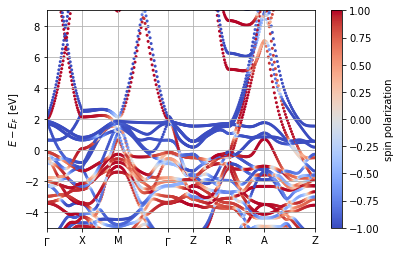

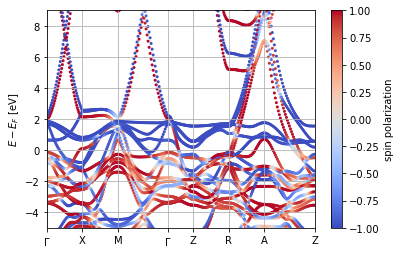

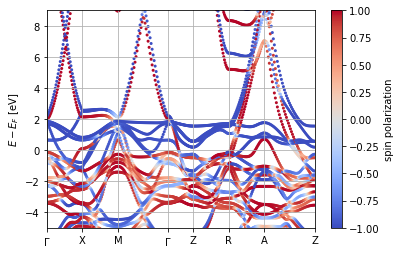

In [48]:
E_F = 16.9627
struc = Structure.from_file('FePt_sym.cif')
kpath = KPathSeek(struc)
kp_label = kpath.kpath["path"][0]

kp_list = []
for kl in kp_label:
    kp_list.append(np.array(kpath.kpath["kpoints"][kl]))
    
for i in range(len(kp_label)):
    if"GAMMA" in kp_label[i]:
        kp_label[i] = "$\Gamma$"

xticks = np.array([
    0.0000,
    0.5000,
    1.0000,
    1.7071,
    2.0571,
    2.5571,
    3.0571,
    3.7642,
])

kp_list_for_dft = np.array([
    [0.00, 0.00, 0.00],
    [0.00, 0.50, 0.00],
    [0.50, 0.50, 0.00],
    [0.00, 0.00, 0.00],
    [0.00, 0.00, 0.35],
    [0.00, 0.50, 0.35],
    [0.50, 0.50, 0.35],
    [0.00, 0.00, 0.35]
])


b_py_hr = Band(ham_py_hr, kp_list, kp_label, E_F, 
         ylim=[-5,9], 
         kp_list_for_dft=kp_list_for_dft, 
         )
b_symmed_hr = Band(ham_symmed_hr, kp_list, kp_label, E_F, 
         ylim=[-5,9], 
         kp_list_for_dft=kp_list_for_dft, 
         )
b_py_symmed_hr = Band(ham_py_symmed_hr, kp_list, kp_label, E_F, 
         ylim=[-5,9], 
         kp_list_for_dft=kp_list_for_dft, 
         )

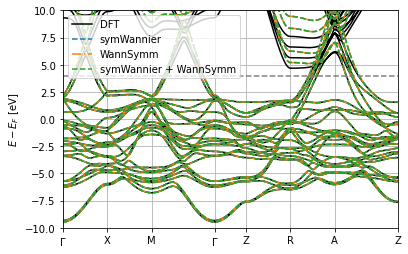

In [49]:
band_dft = pd.read_table("../band/band.gnu", header=None, skip_blank_lines=False, delimiter="\s+")

plt.figure()
plt.plot(band_dft.iloc[:,0]/np.max(band_dft.iloc[:,0]), band_dft.iloc[:,1] - b_py_hr.E_F, color="black", label="DFT")
for nw in range(b_py_hr.num_wann):
    if nw==0:
        plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[nw,:] - b_py_hr.E_F, 
                 color="tab:blue", linestyle="--", label="symWannier")
        plt.plot(b_symmed_hr.l/max(b_symmed_hr.tick_locs), b_symmed_hr.ek_all[nw,:] - b_symmed_hr.E_F, 
                 color="tab:orange", linestyle="dashdot", label="WannSymm")
        plt.plot(b_py_symmed_hr.l/max(b_py_symmed_hr.tick_locs), b_py_symmed_hr.ek_all[nw,:] - b_py_symmed_hr.E_F, 
                 color="tab:green", linestyle="dashed", label="symWannier + WannSymm")
    else:
        plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[nw,:] - b_py_hr.E_F, 
                 color="tab:blue", linestyle="--")
        plt.plot(b_symmed_hr.l/max(b_symmed_hr.tick_locs), b_symmed_hr.ek_all[nw,:] - b_symmed_hr.E_F, 
                 color="tab:orange", linestyle="dashdot")
        plt.plot(b_py_symmed_hr.l/max(b_py_symmed_hr.tick_locs), b_py_symmed_hr.ek_all[nw,:] - b_py_symmed_hr.E_F, 
                 color="tab:green", linestyle="dashed")

plt.hlines(4,0,1, color="grey", linestyle="--")
plt.xlim([0, 1])
plt.xticks(b_py_hr.tick_locs/max(b_py_hr.tick_locs), kp_label)
plt.ylim(-10,10)
plt.grid()
plt.ylabel('$E - E_F$ [eV]')
plt.legend()
plt.savefig("band.pdf")
plt.show()

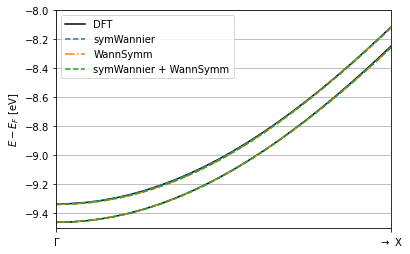

In [50]:
plt.figure()
plt.plot(band_dft.iloc[:,0]/np.max(band_dft.iloc[:,0]), band_dft.iloc[:,1] - b_py_hr.E_F, color="black", label="DFT")
for nw in range(b_py_hr.num_wann):
    if nw==0:
        plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[nw,:] - b_py_hr.E_F, 
                 color="tab:blue", linestyle="--", label="symWannier")
        plt.plot(b_symmed_hr.l/max(b_symmed_hr.tick_locs), b_symmed_hr.ek_all[nw,:] - b_symmed_hr.E_F, 
                 color="tab:orange", linestyle="dashdot", label="WannSymm")
        plt.plot(b_py_symmed_hr.l/max(b_py_symmed_hr.tick_locs), b_py_symmed_hr.ek_all[nw,:] - b_py_symmed_hr.E_F, 
                 color="tab:green", linestyle="dashed", label="symWannier + WannSymm")
    else:
        plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[nw,:] - b_py_hr.E_F, 
                 color="tab:blue", linestyle="--")
        plt.plot(b_symmed_hr.l/max(b_symmed_hr.tick_locs), b_symmed_hr.ek_all[nw,:] - b_symmed_hr.E_F, 
                 color="tab:orange", linestyle="dashdot")
        plt.plot(b_py_symmed_hr.l/max(b_py_symmed_hr.tick_locs), b_py_symmed_hr.ek_all[nw,:] - b_py_symmed_hr.E_F, 
                 color="tab:green", linestyle="dashed")

plt.xticks([0,0.06],["$\Gamma$", "$\\rightarrow$ X"])

plt.xlim(0, 0.06)
plt.ylim(-9.5, -8)
plt.grid()
plt.ylabel('$E - E_F$ [eV]')
plt.legend()
# plt.savefig("band_detail.pdf")
plt.show()

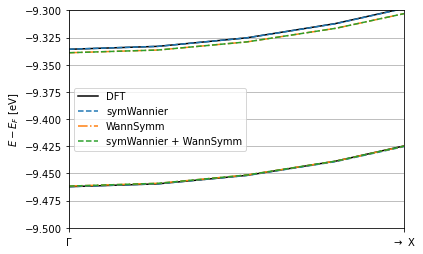

In [51]:
plt.figure()
plt.plot(band_dft.iloc[:,0]/np.max(band_dft.iloc[:,0]), band_dft.iloc[:,1] - b_py_hr.E_F, color="black", label="DFT")
for nw in range(b_py_hr.num_wann):
    if nw==0:
        plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[nw,:] - b_py_hr.E_F, 
                 color="tab:blue", linestyle="--", label="symWannier")
        plt.plot(b_symmed_hr.l/max(b_symmed_hr.tick_locs), b_symmed_hr.ek_all[nw,:] - b_symmed_hr.E_F, 
                 color="tab:orange", linestyle="dashdot", label="WannSymm")
        plt.plot(b_py_symmed_hr.l/max(b_py_symmed_hr.tick_locs), b_py_symmed_hr.ek_all[nw,:] - b_py_symmed_hr.E_F, 
                 color="tab:green", linestyle="dashed", label="symWannier + WannSymm")
    else:
        plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[nw,:] - b_py_hr.E_F, 
                 color="tab:blue", linestyle="--")
        plt.plot(b_symmed_hr.l/max(b_symmed_hr.tick_locs), b_symmed_hr.ek_all[nw,:] - b_symmed_hr.E_F, 
                 color="tab:orange", linestyle="dashdot")
        plt.plot(b_py_symmed_hr.l/max(b_py_symmed_hr.tick_locs), b_py_symmed_hr.ek_all[nw,:] - b_py_symmed_hr.E_F, 
                 color="tab:green", linestyle="dashed")

plt.xticks([0,0.01],["$\Gamma$", "$\\rightarrow$ X"])

plt.xlim(0, 0.01)
plt.ylim(-9.5, -9.3)
plt.grid()
plt.ylabel('$E - E_F$ [eV]')
plt.legend()
plt.savefig("band_detail.pdf")
plt.show()

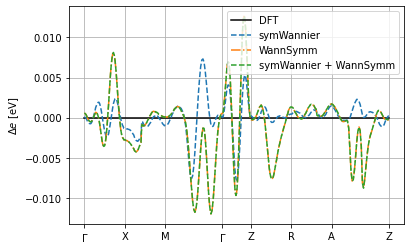

In [72]:
plt.figure()
plt.plot(band_dft.iloc[2816:3167,0]/np.max(band_dft.iloc[:,0]), 
         band_dft.iloc[2816:3167,1] - band_dft.iloc[2816:3167,1], color="black", label="DFT")

plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[0,:] - band_dft.iloc[2816:3167,1], 
            color="tab:blue", linestyle="--", label="symWannier")
plt.plot(b_symmed_hr.l/max(b_symmed_hr.tick_locs), b_symmed_hr.ek_all[0,:] - band_dft.iloc[2816:3167,1], 
            color="tab:orange", linestyle="dashdot", label="WannSymm")
plt.plot(b_py_symmed_hr.l/max(b_py_symmed_hr.tick_locs), b_py_symmed_hr.ek_all[0,:] - band_dft.iloc[2816:3167,1], 
            color="tab:green", linestyle="dashed", label="symWannier + WannSymm")

plt.xticks(b_py_hr.tick_locs/max(b_py_hr.tick_locs), kp_label)

#plt.xlim(0, 0.01)
#plt.ylim(-9.5, -9.3)
plt.grid()
plt.ylabel('$\Delta e$ [eV]')
plt.legend()
plt.show()

2023-08-25 18:56:09,456 [wannier_utils.hamiltonian INFO]: Reading pwscf_hr.dat ...
2023-08-25 18:56:10,044 [wannier_utils.hamiltonian INFO]: Reading pwscf_hr.dat is Done.
2023-08-25 18:56:10,279 [wannier_utils.hamiltonian INFO]: Reading pwscf_py_hr.dat ...
2023-08-25 18:56:10,826 [wannier_utils.hamiltonian INFO]: Reading pwscf_py_hr.dat is Done.


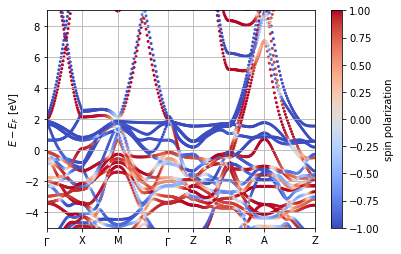

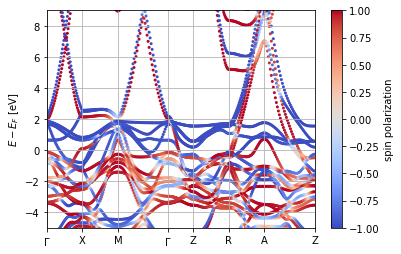

In [52]:
ham_hr = MagRotation( 
            hr_dat=Path("pwscf_hr.dat"), 
            extract_only_x_component=0,
            use_convert_ham_r=0,
            nnkp_file=Path("../wan/pwscf.nnkp"),
            win_file=Path("../wan/pwscf.win"),
        )
ham_py_hr1 = MagRotation( 
            hr_dat=Path("pwscf_py_hr.dat"), 
            extract_only_x_component=1,
            use_convert_ham_r=0,
            nnkp_file=Path("../wan/pwscf.nnkp"),
            win_file=Path("../wan/pwscf.win"),
        )
b_hr = Band(ham_hr, kp_list, kp_label, E_F, 
            ylim=[-5,9], 
            kp_list_for_dft=kp_list_for_dft, 
         )
b_py_hr1 = Band(ham_py_hr1, kp_list, kp_label, E_F, 
            ylim=[-5,9], 
            kp_list_for_dft=kp_list_for_dft, 
         )

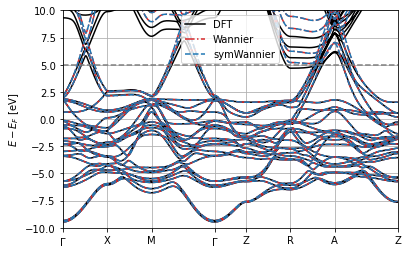

In [53]:
plt.figure()
plt.plot(band_dft.iloc[:,0]/np.max(band_dft.iloc[:,0]), band_dft.iloc[:,1] - b_py_hr.E_F, color="black", label="DFT")
for nw in range(b_py_hr.num_wann):
    if nw==0:
        plt.plot(b_hr.l/max(b_hr.tick_locs), b_hr.ek_all[nw,:] - b_hr.E_F, 
                 color="tab:red", linestyle="dashdot", label="Wannier")
        plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[nw,:] - b_py_hr.E_F, 
                 color="tab:blue", linestyle="dashed", label="symWannier")
    else:
        plt.plot(b_py_hr.l/max(b_hr.tick_locs), b_hr.ek_all[nw,:] - b_hr.E_F, 
                 color="tab:red", linestyle="dashdot")
        plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[nw,:] - b_py_hr.E_F, 
                 color="tab:blue", linestyle="dashed")

plt.hlines(5,0,1, color="grey", linestyle="--")
plt.xlim([0, 1])
plt.xticks(b_py_hr.tick_locs/max(b_py_hr.tick_locs), kp_label)
plt.ylim(-10,10)
plt.grid()
plt.ylabel('$E - E_F$ [eV]')
plt.legend()

plt.show()

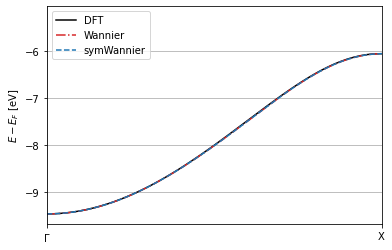

In [63]:
plt.figure()
plt.plot(band_dft.iloc[2816:3167,0]/np.max(band_dft.iloc[:,0]), 
         band_dft.iloc[2816:3167,1] - b_py_hr.E_F, color="black", label="DFT")

plt.plot(b_hr.l/max(b_hr.tick_locs), b_hr.ek_all[0,:] - b_hr.E_F, 
            color="tab:red", linestyle="dashdot", label="Wannier")
plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[0,:] - b_py_hr.E_F, 
            color="tab:blue", linestyle="dashed", label="symWannier")

plt.xticks([0,0.5/3.7642],["$\Gamma$", "X"])

plt.xlim(0, 0.5/3.7642)
#plt.ylim(-9.5, -9.3)
plt.grid()
plt.ylabel('$E - E_F$ [eV]')
plt.legend()
plt.show()

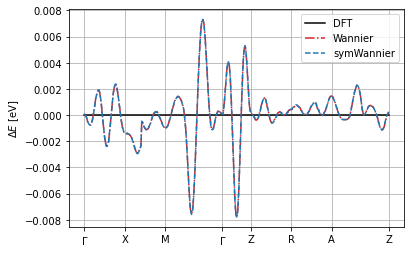

In [68]:
plt.figure()
plt.plot(band_dft.iloc[2816:3167,0]/np.max(band_dft.iloc[:,0]), 
         band_dft.iloc[2816:3167,1] - band_dft.iloc[2816:3167,1], color="black", label="DFT")

plt.plot(b_hr.l/max(b_hr.tick_locs), b_hr.ek_all[0,:] - band_dft.iloc[2816:3167,1], 
            color="tab:red", linestyle="dashdot", label="Wannier")
plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[0,:] - band_dft.iloc[2816:3167,1], 
            color="tab:blue", linestyle="dashed", label="symWannier")

#plt.xticks([0,0.5/3.7642],["$\Gamma$", "X"])
plt.xticks(b_py_hr.tick_locs/max(b_py_hr.tick_locs), kp_label)

#plt.xlim(0, 0.5/3.7642)
#plt.ylim(-9.5, -9.3)
plt.grid()
plt.ylabel('$\Delta E$ [eV]')
plt.legend()
plt.show()

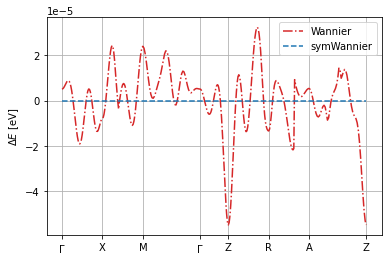

In [69]:
plt.figure()

plt.plot(b_hr.l/max(b_hr.tick_locs), b_hr.ek_all[0,:] - b_py_hr.ek_all[0,:], 
            color="tab:red", linestyle="dashdot", label="Wannier")
plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[0,:] - b_py_hr.ek_all[0,:], 
            color="tab:blue", linestyle="dashed", label="symWannier")


#plt.xticks([0, 0.5/3.7642],["$\Gamma$", "X"])
plt.xticks(b_py_hr.tick_locs/max(b_py_hr.tick_locs), kp_label)
#plt.xlim(0, 0.5/3.7642)
#plt.xlim(0,0.01)

plt.grid()
plt.ylabel('$\Delta E$ [eV]')
plt.legend()
plt.show()

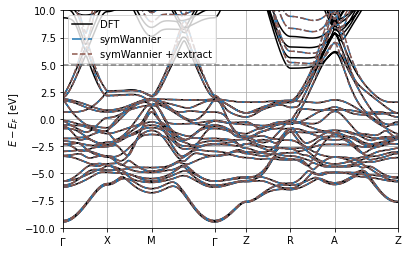

In [55]:
plt.figure()
plt.plot(band_dft.iloc[:,0]/np.max(band_dft.iloc[:,0]), band_dft.iloc[:,1] - b_py_hr.E_F, color="black", label="DFT")
for nw in range(b_py_hr.num_wann):
    if nw==0:
        plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[nw,:] - b_py_hr.E_F, 
                 color="tab:blue", linestyle="dashdot", label="symWannier")
        plt.plot(b_py_hr1.l/max(b_py_hr1.tick_locs), b_py_hr1.ek_all[nw,:] - b_py_hr1.E_F, 
                 color="tab:brown", linestyle="dashed", label="symWannier + extract")
    else:
        plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[nw,:] - b_py_hr.E_F, 
                 color="tab:blue", linestyle="dashdot")
        plt.plot(b_py_hr1.l/max(b_py_hr1.tick_locs), b_py_hr1.ek_all[nw,:] - b_py_hr1.E_F, 
                 color="tab:brown", linestyle="dashed")

plt.hlines(5,0,1, color="grey", linestyle="--")
plt.xlim([0, 1])
plt.xticks(b_py_hr.tick_locs/max(b_py_hr.tick_locs), kp_label)
plt.ylim(-10,10)
plt.grid()
plt.ylabel('$E - E_F$ [eV]')
plt.legend()

plt.show()

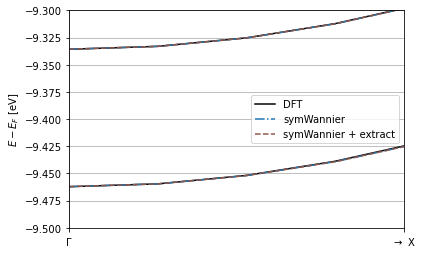

In [56]:
plt.figure()
plt.plot(band_dft.iloc[:,0]/np.max(band_dft.iloc[:,0]), band_dft.iloc[:,1] - b_py_hr.E_F, color="black", label="DFT")
for nw in range(b_py_hr.num_wann):
    if nw==0:
        plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[nw,:] - b_py_hr.E_F, 
                 color="tab:blue", linestyle="dashdot", label="symWannier")
        plt.plot(b_py_hr1.l/max(b_py_hr1.tick_locs), b_py_hr1.ek_all[nw,:] - b_py_hr1.E_F, 
                 color="tab:brown", linestyle="dashed", label="symWannier + extract")
    else:
        plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[nw,:] - b_py_hr.E_F, 
                 color="tab:blue", linestyle="dashdot")
        plt.plot(b_py_hr1.l/max(b_py_hr1.tick_locs), b_py_hr1.ek_all[nw,:] - b_py_hr1.E_F, 
                 color="tab:brown", linestyle="dashed")

plt.xticks([0,0.01],["$\Gamma$", "$\\rightarrow$ X"])

plt.xlim(0, 0.01)
plt.ylim(-9.5, -9.3)
plt.grid()
plt.ylabel('$E - E_F$ [eV]')
plt.legend()
plt.show()

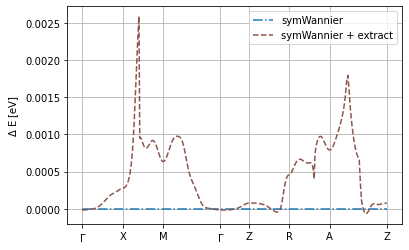

In [73]:
plt.figure()
#plt.plot(band_dft.iloc[2816:3167,0]/np.max(band_dft.iloc[:,0]), 
#         band_dft.iloc[2816:3167,1] - band_dft.iloc[2816:3167,1], color="grey", label="DFT")

plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[0,:] - b_py_hr.ek_all[0,:], 
            color="tab:blue", linestyle="dashdot", label="symWannier")
plt.plot(b_py_hr1.l/max(b_py_hr1.tick_locs), b_py_hr1.ek_all[0,:] - b_py_hr.ek_all[0,:], 
            color="tab:brown", linestyle="dashed", label="symWannier + extract")


#plt.xticks([0,0.01],["$\Gamma$", "$\\rightarrow$ X"])
plt.xticks(b_py_hr.tick_locs/max(b_py_hr.tick_locs), kp_label)

#plt.xlim(0, 0.01)
#plt.ylim(-9.0, -8.8)
plt.grid()
plt.ylabel('$\Delta$ E [eV]')
plt.legend()
plt.show()

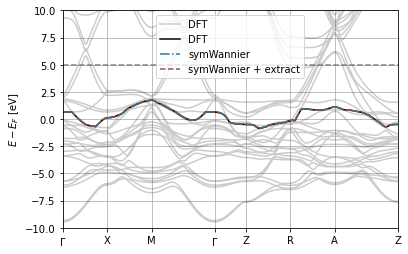

In [123]:
band_dft_x = np.zeros(351)
band_dft_array = np.zeros([351, 98])

for i in range(352*98):
    if not np.isnan(band_dft.iloc[i,0]):
        band_dft_array[i%352, i//352] = band_dft.iloc[i,1]
        band_dft_x[i%352] = band_dft.iloc[i,0]

plt.figure()    
plt.plot(band_dft.iloc[:,0]/np.max(band_dft.iloc[:,0]), 
         band_dft.iloc[:,1] - b_py_hr.E_F, color="black", label="DFT", alpha=0.2)

nb=26
plt.plot(band_dft_x/np.max(band_dft_x), 
         band_dft_array[:,nb] - b_py_hr.E_F, color="black", label="DFT")
nw=18
plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[nw,:] - b_py_hr.E_F, 
            color="tab:blue", linestyle="dashdot", label="symWannier")
plt.plot(b_py_hr1.l/max(b_py_hr1.tick_locs), b_py_hr1.ek_all[nw,:] - b_py_hr1.E_F, 
            color="tab:brown", linestyle="dashed", label="symWannier + extract")

plt.hlines(5,0,1, color="grey", linestyle="--")
plt.xlim([0, 1])
plt.xticks(b_py_hr.tick_locs/max(b_py_hr.tick_locs), kp_label)
plt.ylim(-10,10)
plt.grid()
plt.ylabel('$E - E_F$ [eV]')
plt.legend()

plt.show()

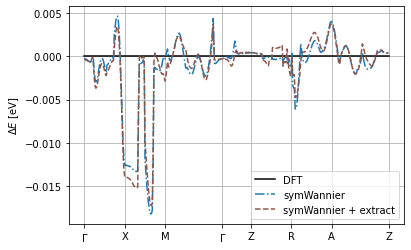

In [124]:
nb=26
plt.plot(band_dft_x/np.max(band_dft_x), 
         band_dft_array[:,nb] - band_dft_array[:,nb], color="black", label="DFT")
nw=18
plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[nw,:] - band_dft_array[:,nb], 
            color="tab:blue", linestyle="dashdot", label="symWannier")
plt.plot(b_py_hr1.l/max(b_py_hr1.tick_locs), b_py_hr1.ek_all[nw,:] - band_dft_array[:,nb], 
            color="tab:brown", linestyle="dashed", label="symWannier + extract")

plt.xticks(b_py_hr.tick_locs/max(b_py_hr.tick_locs), kp_label)
plt.grid()
plt.ylabel('$\Delta E$ [eV]')
plt.legend()

plt.show()

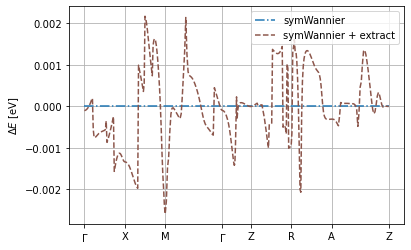

In [125]:
nw=18
plt.plot(b_py_hr.l/max(b_py_hr.tick_locs), b_py_hr.ek_all[nw,:] - b_py_hr.ek_all[nw,:], 
            color="tab:blue", linestyle="dashdot", label="symWannier")
plt.plot(b_py_hr1.l/max(b_py_hr1.tick_locs), b_py_hr1.ek_all[nw,:] - b_py_hr.ek_all[nw,:], 
            color="tab:brown", linestyle="dashed", label="symWannier + extract")

plt.xticks(b_py_hr.tick_locs/max(b_py_hr.tick_locs), kp_label)
plt.grid()
plt.ylabel('$\Delta E$ [eV]')
plt.legend()

plt.show()